In [1]:
import pandas as pd
import os
import deeplog
import torch
from torch import nn
from torch.nn import functional as F
from torch.utils.data import DataLoader, Dataset
from skipgram import *
import scipy

ROOT_DIR = os.path.dirname(os.path.abspath(""))
assert ROOT_DIR.endswith("Synthesis-Project-1"),\
	"Root directory is not Synthesis-Project-1. Ensure your python file is in the 'src/' directory of the repository"

file = os.path.join(ROOT_DIR, "data/sitges_access_clean.csv")
df = pd.read_csv(file)

In [2]:
df_sorted = deeplog.sort_by_group(df)

In [5]:
training_set = deeplog.GroupSequenceDataset(df_sorted[100000:200000].reset_index(drop=True), seq_len=15) # this subset has NO anomalies
validation_set = deeplog.GroupSequenceDataset(df_sorted[200000:300000].reset_index(drop=True), seq_len=15) # this subset has NO anomalies
validation_set2 = deeplog.GroupSequenceDataset(df_sorted[400000:500000].reset_index(drop=True), seq_len=15) # this subset HAS anomalies

Loading embeddings...
Extracting embeddings...


100%|██████████| 100000/100000 [00:10<00:00, 9826.67it/s]


Preparing dataset...


100%|██████████| 100000/100000 [00:12<00:00, 8275.73it/s]


Loading embeddings...
Extracting embeddings...


100%|██████████| 100000/100000 [00:09<00:00, 10012.76it/s]


Preparing dataset...


100%|██████████| 100000/100000 [00:11<00:00, 8467.19it/s]


Loading embeddings...
Extracting embeddings...


100%|██████████| 100000/100000 [00:09<00:00, 10723.50it/s]


Preparing dataset...


100%|██████████| 100000/100000 [00:11<00:00, 8843.29it/s]


In [6]:
train_loader = DataLoader(training_set, batch_size=256, shuffle=True)
val_loader = DataLoader(validation_set, batch_size=256, shuffle=False)
val_loader2 = DataLoader(validation_set2, batch_size=256, shuffle=False)

In [29]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
deeplog_model = deeplog.load_model(os.path.join(ROOT_DIR, "models", "deeplog", "deeplog_1_0.pt"), device)

In [10]:
class AutoEncoder(nn.Module):
	def __init__(self, input_size, hidden_size):
		super(AutoEncoder, self).__init__()
		self.encoder = nn.Sequential(
			nn.Linear(input_size, hidden_size[0]),
			nn.ReLU(),
			nn.Linear(hidden_size[0], hidden_size[1]),
			nn.ReLU(),
			nn.Linear(hidden_size[1], hidden_size[2])
		)
		self.decoder = nn.Sequential(
			nn.Linear(hidden_size[2], hidden_size[1]),
			nn.ReLU(),
			nn.Linear(hidden_size[1], hidden_size[0]),
			nn.ReLU(),
			nn.Linear(hidden_size[0], input_size)
		)

	def forward(self, x):
		emb = self.encoder(x)
		x = self.decoder(emb)
		return x

In [16]:
def train_autoencoder(model, train_loader, epochs, device):
	optimizer = torch.optim.Adam(model.parameters(), lr=0.001)
	criterion = nn.MSELoss()
	losses = []
	model.train()
	for epoch in range(epochs):
		for i, (_, pv) in enumerate(train_loader):
			pv = pv.to(device)
			optimizer.zero_grad()
			output = model(pv)
			loss = criterion(output, pv)
			loss.backward()
			optimizer.step()
			losses.append(loss.item())
			print(f"Epoch {epoch+1}, Batch {i+1}, Loss: {loss.item()}", end="\r")
		print()
	return losses

In [44]:
def evaluate_autoencoder(model, val_loader, device):
	losses = []
	model.eval()
	criterion = nn.MSELoss(reduction="none")
	with torch.no_grad():
		for i, (_, pv) in enumerate(val_loader):
			pv = pv.to(device)
			output = model(pv)
			loss = criterion(output, pv)
			losses.extend(loss.mean(dim=1).tolist())
			print(f"Batch {i+1}, Loss: {loss.mean().item()}", end="\r")
		print()
	return losses

In [18]:
autoencoder = AutoEncoder(
	input_size=training_set.pv_vectors.shape[1],
	hidden_size=[100, 64, 32]
)
autoencoder.to(device);

In [19]:
losses = train_autoencoder(autoencoder, train_loader, 1, device)

Epoch 1, Batch 391, Loss: 0.008730336092412472


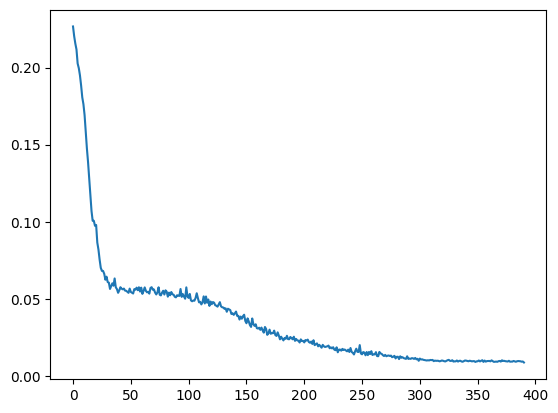

In [21]:
plt.plot(losses);

In [24]:
val_losses = evaluate_autoencoder(autoencoder, val_loader, device)
np.array(val_losses).mean(), np.array(val_losses).std()

(0.009404458404492463, 0.0009019197033211469)

In [45]:
ae_losses = evaluate_autoencoder(autoencoder, val_loader2, device)
ae_losses = torch.tensor(ae_losses)
ae_losses.mean(), ae_losses.std()

Batch 391, Loss: 0.022649567574262622


(tensor(0.0232), tensor(0.0051))

In [32]:
dl_losses, dl_anomalies, dl_probs = [], [], []
for x, y in tqdm(val_loader2, total=len(val_loader2)):
	x, y = x.to(device), y.to(device)
	losses, anomalies, probs = deeplog_model.detect(x, y, seq_norm=False, return_probs=True)
	dl_losses.append(losses)
	dl_anomalies.append(anomalies)
	dl_probs.append(probs)
dl_losses = torch.cat(dl_losses).cpu()
dl_anomalies = torch.cat(dl_anomalies).cpu()
dl_probs = torch.cat(dl_probs).cpu()

100%|██████████| 391/391 [00:12<00:00, 30.81it/s]


In [37]:
dl_losses.mean(), dl_losses.std()

(tensor(0.1886), tensor(0.0306))

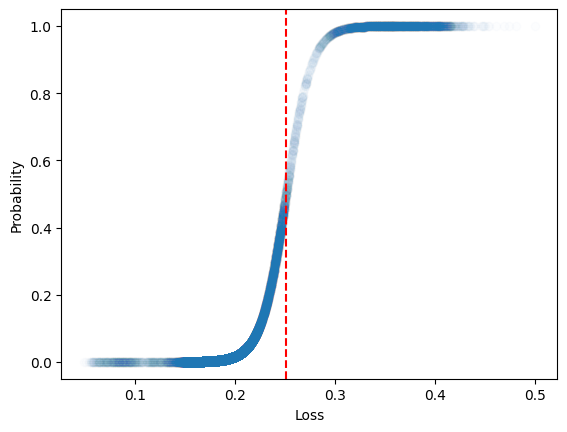

In [35]:
plt.scatter(dl_losses, dl_probs, alpha=0.01)
plt.axvline(deeplog_model.iqr_interval[1], color="r", linestyle="--")
plt.xlabel("Loss")
plt.ylabel("Probability");

In [62]:
l1_mean, l1_std = dl_losses.mean(), dl_losses.std()
l2_mean, l2_std = ae_losses.mean(), ae_losses.std()

l1_z_norm = (dl_losses - l1_mean) / l1_std
l2_z_norm = (ae_losses - l2_mean) / l2_std

comb_losses = (l1_z_norm + l2_z_norm) / 2
comb_losses.mean(), comb_losses.std()

(tensor(-1.8982e-07), tensor(0.7727))

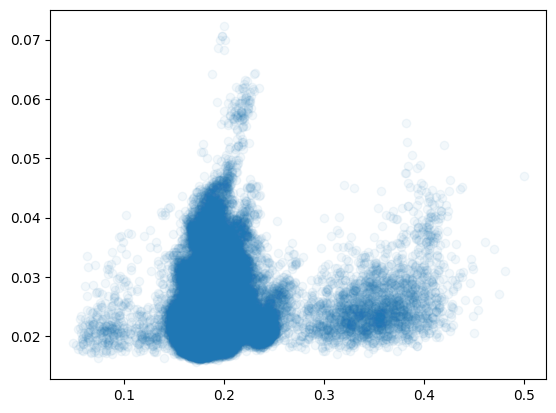

In [49]:
plt.plot(dl_losses, ae_losses, "o", alpha=0.05);

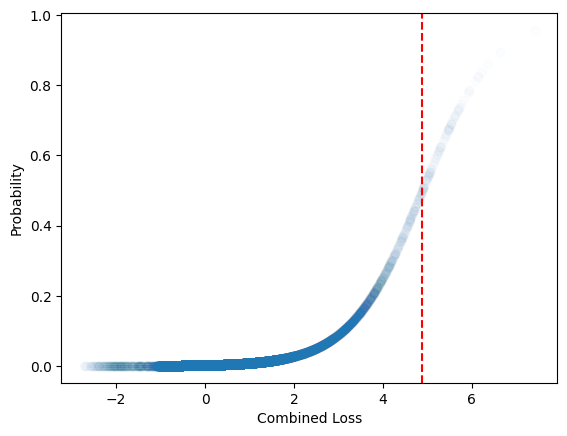

In [115]:
thresh = comb_losses.quantile(0.999)
iqr_width = comb_losses.quantile(0.75) - comb_losses.quantile(0.25)
distances = (comb_losses - thresh) / iqr_width
comb_probs = torch.sigmoid(distances)
plt.plot(comb_losses, comb_probs, "o", alpha=0.01)
plt.axvline(thresh, color="r", linestyle="--")
plt.xlabel("Combined Loss")
plt.ylabel("Probability");

In [103]:
# vals, indices = torch.topk(comb_probs, 50)
indices = torch.where(comb_probs > 0.0001)[0]
anomalies = df_sorted[400000:500000].iloc[indices]
anomalies["user-agent"].value_counts()
# anomalies[["IP_oct0", "IP_oct1", "IP_oct2", "IP_oct3"]]

user-agent
Mozilla/5.0 (compatible; AhrefsBot/7.0; +http://ahrefs.com/robot/)    99993
Name: count, dtype: int64

In [117]:
df_sorted[0:100000]["URL"].value_counts()

URL
/plantilles/turisme/img/logo-top.svg HTTP/2.0                                                                2023
/media/site1/cache/images/instagram-logo-x2.png HTTP/2.0                                                     1846
/media/site1/cache/images/facebook-logo-x2.png HTTP/2.0                                                      1844
/media/site1/cache/images/youtube-logo-x2.png HTTP/2.0                                                       1838
/media/site1/cache/images/twitter-logo-x2.png HTTP/2.0                                                       1837
                                                                                                             ... 
/noticias/163/sitges-tanca-a-berl%C3%ADn-la-promoci%C3%B3-per-consolidar-el-turisme-alemany.html HTTP/1.1       1
/ca/pl409/blog/id46/posta-de-sol-a-sitges.htm HTTP/2.0                                                          1
/media/site1/cache/images/puestadesol2-redim-w4277-h2850.jpg HTTP/2.0               